## 2018 VEST MI

**Files + Sources: From VEST Documentation** 

2018GEN.zip: Election results from Michigan Secretary of State (https://miboecfr.nictusa.com/cgi-bin/cfr/precinct_srch.cgi)

2018_Voting_Precincts-shp.zip: Election shapefile from Michigan GIS Open Data site (https://gis-michigan.opendata.arcgis.com/datasets/2018-voting-precincts)
https://gis-michigan.opendata.arcgis.com/datasets/2018-voting-precincts?geometry=108.333%2C43.318%2C-105.418%2C84.231

mi_2018.zip: VEST final file

----- 

Detroit 125 does not appear in the state's shapefile. Looking at a PDF on the city's website, it looks like it is some part of 494, but the boundary is not clear, so these results were merged together.

A few counties use Absent Voter Counting Boards to report some or all absentee results. In some cases, these align with a single precinct, but in others, they correspond to multiple precincts. Notable in this is that all of Detroit uses AVCBs, of which each is made up of multiple precincts. These were distributed by candidate to precincts based on election day totals. Thank you to Derek Willis of OpenElections for the file linking Detroit precincts to AVCBs.

Some counties report "Statistical Adjustments" with their precinct results which make the sum of the precinct totals match the official results. These can be positive or negative. In many cases these adjustments are small, but two cases are notable: Muskegon County has a +4630 adjustment for gubernatorial candidate Tood Schleiger and Barry County has a -722 adjustment for SBE candidate Tami Carlone. None of these adjustments, small or large, were distributed to precincts, which may result in candidate totals being slightly off official totals.

Write-in vote totals have been excluded, since in most cases, a large share of their votes are accounted for via statistical adjustments. (For example, 1647 of MSU Trustee candidate David Mott's 1673 votes are found in these countywide figures.)

Oakland County's Fenton precinct 2 results merged into Genesee County's Fenton precinct 2.
St. Clair County's Richmond precinct 1 results merged into Macomb County's Richmond precinct 1.


In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import maup
from zipfile import ZipFile
import numpy as np

In [3]:
#First, unzip all files that will be used for processing
def unzip(zip_file_name, unzipped_file_name):
    with ZipFile(zip_file_name, 'r') as zipobj:
        zipobj.extractall(unzipped_file_name)

# Load Partner File

In [7]:
gdfv = gpd.read_file('./mi_2018/mi_2018.shp')
gdfv.head()

,OBJECTID,PRECINCTID,ELECTIONYE,COUNTYFIPS,MCDFIPS,WARD,PRECINCT,ShapeSTAre,ShapeSTLen,precinct_2,...,G18UBRNABR,G18UBRRDUN,G18UBRRNIC,G18UBRDBAR,G18UBRDKUM,G18UBRLELG,G18UBRLHAR,G18UBRTSCH,G18UBRTSOS,geometry
0,1,WP-001-01040-00001,2018,001,01040,00,001,1.701076e+08,73869.558748,001-ALCONA TOWNSHIP-0-0001,...,7,375,355,181,160,7,11,19,9,"POLYGON ((713885.576 472642.367, 713798.715 47..."
1,2,WP-001-12460-00001,2018,001,12460,00,001,1.880860e+08,76737.144518,001-CALEDONIA TOWNSHIP-0-0001,...,5,302,275,151,130,5,6,24,11,"POLYGON ((686272.607 476273.249, 685978.453 47..."
2,3,WP-001-19320-00001,2018,001,19320,00,001,1.833231e+08,57470.528359,001-CURTIS TOWNSHIP-0-0001,...,9,258,234,173,138,12,9,29,16,"POLYGON ((686986.253 442623.144, 686677.696 44..."
3,4,WP-001-34820-00001,2018,001,34820,00,001,6.767958e+07,32987.191075,001-GREENBUSH TOWNSHIP-0-0001,...,14,340,319,216,189,12,12,20,12,"POLYGON ((712947.018 443503.339, 712791.603 44..."
4,5,WP-001-35740-00001,2018,001,35740,00,001,9.281010e+07,38642.299469,001-GUSTIN TOWNSHIP-0-0001,...,5,152,155,72,56,6,5,17,7,"POLYGON ((705992.472 452886.004, 704976.166 45..."


# Election Results

## Loading

I was not able to load in the tab file - even specifying delimeter it read all columns in as one. As a result, I opened the tab file in an editor, used find and replace tab --> ',' and saved the file as a csv to read it in here.

In [10]:
df = pd.read_csv('votes_tab_to_csv.csv', names = ['Election Year', 'Election Type', 'Office Code', 'District Code', 'Status Code', 'Candidate ID#', 'County Code', 'City/Town Code', 'Ward Number', 'Precinct Number', 'Precinct Label', 'Precinct #Votes'])
df.head()

,Election Year,Election Type,Office Code,District Code,Status Code,Candidate ID#,County Code,City/Town Code,Ward Number,Precinct Number,Precinct Label,Precinct #Votes
0,2018,GEN,0,0,0,0,1,2,0,1,NaN,687
1,2018,GEN,0,0,0,0,1,4,0,1,NaN,591
2,2018,GEN,0,0,0,0,1,6,0,1,NaN,586
3,2018,GEN,0,0,0,0,1,8,0,1,NaN,701
4,2018,GEN,0,0,0,0,1,10,0,1,NaN,316


## Processing

In [11]:
df['Office Code'].nunique()

15

In [12]:
df['Candidate ID#'].nunique()

503

Number of unique rows per candidate.

In [13]:
val_counts = df['Candidate ID#'].value_counts()
val_counts.max()

5093

In [17]:
val_counts[val_counts==5093].count()

19

Number of unique rows per candidate excluding absentee.

In [14]:
df[df['Precinct Label'].isna()]['Candidate ID#'].value_counts().max()

4832

Comparing with vest `gdfv` observe > 99% match in the number of precincts in the source file and in `gdf`

In [16]:
gdfv.shape[0]/df[df['Precinct Label'].isna()]['Candidate ID#'].value_counts().max()

0.9927566225165563

In order to recreate VEST's final file, I need the names file to match the office names with candidate names. Then can merge witth the votes file and pivot. Used same process as with the votes file to convert tab file to csv.

In [18]:
names = pd.read_csv('./2018GEN/names_tab_to_csv.csv')
names.columns = [x.strip() for x in names.columns]
names.head()

,year,election_type,office_code,district_code,status_code,candidate_id_#,last_name,first_name,middle_name,party_name
0,2018,GEN,2,0,0,517093,LYNCH,CLYDE,NPA,NaN
1,2018,GEN,2,0,0,517245,SCHLEIGER,TODD,UST,NaN
2,2018,GEN,2,0,0,518014,WHITMER,GRETCHEN,DEM,NaN
3,2018,GEN,2,0,0,518016,COBBS,WILLIAM,NPA,NaN
4,2018,GEN,2,0,0,518032,SPACE,EVAN,NPA,NaN


Using names df to recreate VEST naming convention

In [19]:
names.loc[names.party_name.isna(), 'party_name'] = names.middle_name
##Account for people with no middle name where party name incorrectly placed there

In [20]:
names.party_name.value_counts()

DEM    177
REP    174
NPA     59
LIB     43
UST     20
GRN     17
WCP     11
NLP      4
Name: party_name, dtype: int64

Assigning party letter by party name to insert for Vest name convention (office, party letter, last name first 3)

In [21]:
names['party_letter'] = names.party_name.apply(lambda x: x[0] if x != 'UST' and x != 'NPA' else 'I' if x=='NPA' else 'T')
#NPA = "no party affiliation",  UST = "US Taxpayer" = T by VEST

In [22]:
names.party_letter.value_counts()

D    177
R    174
I     59
L     43
T     20
G     17
W     11
N      4
Name: party_letter, dtype: int64

In [23]:
names['last_name'] = names['last_name'].str.strip()
names['vest_suffix'] = names['party_letter'] + names['last_name'].str.slice(stop=3)
names['vest_suffix']

0      ILYN
1      TSCH
2      DWHI
3      ICOB
4      ISPA
       ... 
500    IYES
501     INO
502    IYES
503     INO
504    IYES
Name: vest_suffix, Length: 505, dtype: object

In [24]:
#dictionary converting codes - candidateID to party letter+last names - use the candidateID# series with vest suffix for the dictionary key
id_to_vest_suffix = pd.Series(names['vest_suffix'].values, index = names['candidate_id_#']).to_dict()

In [25]:
#dictionary matching candidateID to party names
id_to_party = pd.Series(names['party_letter'].values, index = names['candidate_id_#']).to_dict()

Use name file to create dictionaries for candidate ID to candidate name

In [26]:
#dictionary converting codes - candidateID to last names
id_to_name = pd.Series(names['last_name'].values, index = names['candidate_id_#']).to_dict()

In [27]:
#strip id_to_name to just be 3 letters to match vest
id_to_name_3 = {id:name.strip()[0:3] for id, name in id_to_name.items()}

In [28]:
#add mapped column with candidate name from names to vote_df
df['Candidate Name'] = df['Candidate ID#'].map(id_to_name_3)

In [29]:
df['Candidate Name'].isna().value_counts()

False    652948
True       5083
Name: Candidate Name, dtype: int64

In [30]:
#office code dict
office_code = {'0': 'NaN', #Ballot Initiative?
               '1': 'POTUS', #POTUS - No 2018 race
               '2': 'G18GOV',#Governor 
               '3': 'G18SOS',#Secretary of State 
               '4': 'G18ATG',#Attorney General 
               '5': 'G18USS',#US Senate 
               '6': 'USRepCongress', #Congress - No 2018 race?
               '7': 'state_senate',#StateSenate - No 2018 race?
               '8': 'state_rep', #StateRepresentative - No 2018 race?
               '9': 'G18SBE',#state board of education,
               '10': 'G18UBR',#board of regents
               '11': 'G18UBR',#board of trustees
               '12': 'G18UBR',#board of governors
               '13': 'JustSupCrt', 
               '14': 'NaN',
               '90': 'StBallotProposals'}
prefix = df['vest_prefix'] = df['Office Code'].map(lambda x: office_code.get(str(x)))
prefix.value_counts()

G18UBR               147513
state_rep             96859
G18GOV                96767
USRepCongress         57879
G18SBE                55946
G18USS                45783
state_senate          45414
StBallotProposals     30506
JustSupCrt            30504
G18ATG                25410
G18SOS                20332
NaN                    5118
Name: Office Code, dtype: int64

In [32]:
#map vest suffix into votes df
suffix = df['vest_suffix'] = df['Candidate ID#'].map(id_to_vest_suffix)
suffix.value_counts()

TSAN    15266
IWIL    15264
INO     15253
IYES    15253
TSCH    10177
        ...  
RINM       36
DO'N       36
IBOR       35
DCAB       34
REIC       33
Name: Candidate ID#, Length: 427, dtype: int64

In [33]:
#recreate vest name by combining prefix and suffix
df['vest'] = prefix + suffix

In [35]:
df

,Election Year,Election Type,Office Code,District Code,Status Code,Candidate ID#,County Code,City/Town Code,Ward Number,Precinct Number,Precinct Label,Precinct #Votes,Candidate Name,vest_prefix,vest_suffix,vest
0,2018,GEN,0,0,0,0,1,2,0,1,NaN,687,NaN,NaN,NaN,NaN
1,2018,GEN,0,0,0,0,1,4,0,1,NaN,591,NaN,NaN,NaN,NaN
2,2018,GEN,0,0,0,0,1,6,0,1,NaN,586,NaN,NaN,NaN,NaN
3,2018,GEN,0,0,0,0,1,8,0,1,NaN,701,NaN,NaN,NaN,NaN
4,2018,GEN,0,0,0,0,1,10,0,1,NaN,316,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658026,2018,GEN,90,0,3,-1268,83,32,0,1,NaN,240,YES,StBallotProposals,IYES,StBallotProposalsIYES
658027,2018,GEN,90,0,3,-1268,83,52,0,1,NaN,785,YES,StBallotProposals,IYES,StBallotProposalsIYES
658028,2018,GEN,90,0,3,-1268,83,52,0,2,NaN,694,YES,StBallotProposals,IYES,StBallotProposalsIYES
658029,2018,GEN,90,0,3,-1268,83,52,0,3,NaN,760,YES,StBallotProposals,IYES,StBallotProposalsIYES


Find the difference between the set of column names in `gdfv` and the set of values in `df.vest`. 

In [38]:
gdf_col = set(gdfv.columns)
df_col = set(df['vest'])

not_candidates = {
'COUNTYFIPS',
 'ELECTIONYE',
 'MCDFIPS',
 'OBJECTID',
 'PRECINCT',
 'PRECINCTID',
 'ShapeSTAre',
 'ShapeSTLen',
 'WARD',
 'geometry',
 'precinct_2'
}

In [39]:
diff = gdf_col - df_col
diff

{'COUNTYFIPS',
 'ELECTIONYE',
 'G18ATGIGAR',
 'G18UBRTSA1',
 'G18UBRTSA2',
 'MCDFIPS',
 'OBJECTID',
 'PRECINCT',
 'PRECINCTID',
 'ShapeSTAre',
 'ShapeSTLen',
 'WARD',
 'geometry',
 'precinct_2'}

In [41]:
vest_candidates = gdf_col.difference(not_candidates)
vest_candidates.difference(df['vest'])
#See typos in df

{'G18ATGIGAR', 'G18UBRTSA1', 'G18UBRTSA2'}

2018,GEN,11,00000,0,519023,SANGER,JANET,M.,UST
2018,GEN,11,00000,0,519024,SANGER,JOHN,PAUL,UST
These two candidates resulted in the same "Vest name" so they differentiated with a digit. This cell makes that correction
G18ATGIGAR - Chris Graveline (Independent) should be `G18ATGIGRA` in vest's naming scheme, but it looks like they have a typo. This matches the votes to their typo


In [42]:
df.loc[(df['Candidate ID#'] == 519023), 'vest'] = 'G18UBRTSA1'
df.loc[df['Candidate ID#'] == 519024, 'vest'] = 'G18UBRTSA2'
df.loc[df['Candidate ID#'] == 518994, 'vest'] = 'G18ATGIGAR'
vest_candidates.difference(df['vest'])

set()

In [43]:
df = df[df.vest.isin(vest_candidates)] #mask for candidates that vest has only
df.head(2)

,Election Year,Election Type,Office Code,District Code,Status Code,Candidate ID#,County Code,City/Town Code,Ward Number,Precinct Number,Precinct Label,Precinct #Votes,Candidate Name,vest_prefix,vest_suffix,vest
10176,2018,GEN,2,0,0,517245,1,2,0,1,NaN,0,SCH,G18GOV,TSCH,G18GOVTSCH
10177,2018,GEN,2,0,0,517245,1,4,0,1,NaN,2,SCH,G18GOV,TSCH,G18GOVTSCH


Matched columns with vest above, now need to match the rows - get votes precincts to match vest precincts

In [44]:
gdfv['precinct_2']

0           001-ALCONA TOWNSHIP-0-0001
1        001-CALEDONIA TOWNSHIP-0-0001
2           001-CURTIS TOWNSHIP-0-0001
3        001-GREENBUSH TOWNSHIP-0-0001
4           001-GUSTIN TOWNSHIP-0-0001
                     ...              
4792          161-SCIO TOWNSHIP-0-0001
4793          161-SCIO TOWNSHIP-0-0008
4794    163-BROWNSTOWN TOWNSHIP-0-0003
4795      149-LOCKPORT TOWNSHIP-0-0001
4796    161-PITTSFIELD TOWNSHIP-0-0009
Name: precinct_2, Length: 4797, dtype: object

In [46]:
prec2_last5 = gdfv['precinct_2'].str.slice(start = -6)
prec2_last5.nunique()

799

In [47]:
ward_prec = df['Ward Number'].map(lambda x: str(x).zfill(2))+df['Precinct Number'].map(lambda x: str(x).zfill(4))
ward_prec.nunique()

931

In [50]:
gdfv['PRECINCTID'].str.slice(start=3, stop=6).value_counts()

163    988
125    515
099    338
081    252
049    215
      ... 
119      9
013      8
135      7
083      5
095      4
Name: PRECINCTID, Length: 83, dtype: int64

There are 83 counties in MI, so this sugests that the middle 3 represent county fips codes

In [53]:
len(set(gdfv['PRECINCTID'].str.slice(start=3, stop=6).value_counts()) - set(gdfv['COUNTYFIPS']))

50

In [54]:
len(set(gdfv['precinct_2'].str.slice(stop=3).value_counts()) - set(gdfv['COUNTYFIPS']))

50

To recreate `precinct_2` column, use the city file, and convert tab to csv same way as before.

In [56]:
city = pd.read_csv('./2018GEN/city_tab_to_csv.csv', names = ['ElectionYr', 'ElectionType', 'CountyCode', 'CityTownCode', 'CityTownDesc'])
city.head()

,ElectionYr,ElectionType,CountyCode,CityTownCode,CityTownDesc
0,2018,GEN,1,2,ALCONA TOWNSHIP
1,2018,GEN,1,4,CALEDONIA TOWNSHIP
2,2018,GEN,1,6,CURTIS TOWNSHIP
3,2018,GEN,1,8,GREENBUSH TOWNSHIP
4,2018,GEN,1,10,GUSTIN TOWNSHIP


In [58]:
county_city = city['CountyCode'].map(lambda x: str(x).zfill(2)) + city['CityTownCode'].map(lambda x: str(x).zfill(4))
city['county_w_city'] = county_city
#need county to make the city a unique identifier

In [59]:
city.head()

,ElectionYr,ElectionType,CountyCode,CityTownCode,CityTownDesc,county_w_city
0,2018,GEN,1,2,ALCONA TOWNSHIP,010002
1,2018,GEN,1,4,CALEDONIA TOWNSHIP,010004
2,2018,GEN,1,6,CURTIS TOWNSHIP,010006
3,2018,GEN,1,8,GREENBUSH TOWNSHIP,010008
4,2018,GEN,1,10,GUSTIN TOWNSHIP,010010


In [60]:
df['county_w_city'] = df['County Code'].map(lambda x: str(x).zfill(2)) + df['City/Town Code'].map(lambda x: str(x).zfill(4))

<ipython-input-60-7d21130f77dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['county_w_city'] = df['County Code'].map(lambda x: str(x).zfill(2)) + df['City/Town Code'].map(lambda x: str(x).zfill(4))


In [61]:
city_dict = pd.Series(city['CityTownDesc'].values, index = city['county_w_city']).to_dict()

In [63]:
df['CityNameCode'] = df['county_w_city'].map(city_dict)

<ipython-input-63-1f470eb0eadf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CityNameCode'] = df['county_w_city'].map(city_dict)


In [65]:
set(gdfv['precinct_2'].str.slice(start = 4, stop = -7)).difference(set(df['CityNameCode']))
#So, most of the time matches with middle section of gdf column

{'LANSING CITY-3-',
 'LANSING CITY-3-0',
 'LIVONIA CITY-0',
 'MILAN CITY-0',
 'MONROE CITY-0',
 None}

**First tried to recreate `PRECINCTID` column in order to merge with shp**
To do this, relied on census file with MCDFIPS and city/town/county names. Tried this first since that is the common column between the vest file and the shp. 
This did not end up working...

In [66]:
census = pd.read_csv('./all-geocodes-v2018.csv')
censusmi = census[census['State Code (FIPS)'] == 26]
censusmi.head()

,Summary Level,State Code (FIPS),County Code (FIPS),County Subdivision Code (FIPS),Place Code (FIPS),Consolidtated City Code (FIPS),Area Name (including legal/statistical area description)
13815,40,26,0,0,0,0,Michigan
13816,50,26,1,0,0,0,Alcona County
13817,50,26,3,0,0,0,Alger County
13818,50,26,5,0,0,0,Allegan County
13819,50,26,7,0,0,0,Alpena County


County Subdivision Code (FIPS) = MCDFIPS most of the time, in cases where it is zero, use the Place Code (FIPS)

In [67]:
censusmi[censusmi['Area Name (including legal/statistical area description)'].str.slice(start = -4) == 'city'].head()

,Summary Level,State Code (FIPS),County Code (FIPS),County Subdivision Code (FIPS),Place Code (FIPS),Consolidtated City Code (FIPS),Area Name (including legal/statistical area description)
13904,61,26,1,36860,0,0,Harrisville city
13916,61,26,3,56200,0,0,Munising city
13920,61,26,5,1260,0,0,Allegan city
13926,61,26,5,22740,0,0,Douglas city
13927,61,26,5,27740,0,0,Fennville city


In [68]:
censusmi['Area Name (including legal/statistical area description)'].nunique()

1671

In [70]:
gdfv['MCDFIPS'].nunique() #1522

1522

In [72]:
gdfv['PRECINCTID'].str.slice(start = 7, stop = 12).nunique()

1521

In [73]:
def get_mid_code(row):
    place_code = row['Place Code (FIPS)']
    sub_code = row['County Subdivision Code (FIPS)']
    return (str(place_code).zfill(5) if place_code != 0 else str(sub_code).zfill(5))

def get_wp_prefix(row):
#     notice that some cities have a place code, but not a subdivision code
    formatted_county_code = str(row['County Code (FIPS)']).zfill(3)
    return 'WP-' + formatted_county_code + '-' + get_mid_code(row)

In [74]:
censusmi['census_mid_code'] = censusmi.apply(get_mid_code, axis=1)
censusmi.tail()

<ipython-input-74-70bec69a6e98>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  censusmi['census_mid_code'] = censusmi.apply(get_mid_code, axis=1)


,Summary Level,State Code (FIPS),County Code (FIPS),County Subdivision Code (FIPS),Place Code (FIPS),Consolidtated City Code (FIPS),Area Name (including legal/statistical area description),census_mid_code
15967,162,26,0,0,88940,0,Wyoming city,88940
15968,162,26,0,0,89000,0,Yale city,89000
15969,162,26,0,0,89140,0,Ypsilanti city,89140
15970,162,26,0,0,89260,0,Zeeland city,89260
15971,162,26,0,0,89320,0,Zilwaukee city,89320


In [75]:
censusmi.groupby('Summary Level').nunique()

,State Code (FIPS),County Code (FIPS),County Subdivision Code (FIPS),Place Code (FIPS),Consolidtated City Code (FIPS),Area Name (including legal/statistical area description),census_mid_code
Summary Level,,,,,,,
40,1,1,1,1,1,1,1
50,1,83,1,1,1,83,1
61,1,83,1520,1,1,1334,1520
162,1,1,1,533,1,533,533


In [76]:
df = df[df['Precinct Number'] != 9999]

In [78]:
cdf = censusmi[censusmi['Summary Level'].isin([61, 162])] #remove county and state level (leaving precinct-like places only)
census_mid_code_dict = pd.Series(cdf['census_mid_code'].values, index = cdf['Area Name (including legal/statistical area description)'].str.upper()).to_dict()
df['mid_code'] = df['CityNameCode'].map(census_mid_code_dict)
df.mid_code.value_counts()

22000    39825
34000     4543
29000     3599
84000     3304
03000     3127
         ...  
13760       59
42400       59
04840       59
75880       59
79740       59
Name: mid_code, Length: 1195, dtype: int64

In [79]:
def get_wp(row):
    if row['County Code'] == 82:
        # Detroit's county doesn't use ward numbers
        return str(row['Precinct Number']).zfill(5)
    else:
        return str(row['Ward Number']).zfill(2) + str(row['Precinct Number']).zfill(3)

def get_precinct_id(row):
    return 'WP-' + str(row['County Code']).zfill(3) + '-' + str(row['mid_code']).zfill(5) + '-' + get_wp(row)

df['PRECINCTID'] = df.apply(get_precinct_id, axis=1)
df['wp'] = df.apply(get_wp, axis=1)

In [80]:
df_wps = set(df.wp.unique())
len(df_wps)

890

In [81]:
gdf_wps = set(gdfv.wp.unique())
len(gdf_wps)

AttributeError: 'GeoDataFrame' object has no attribute 'wp'

### Come back to ^

#### Recreate `precinct_2`

Need to recreate the `precinct_2`  - the `PRECINCTID` column is from the shp and VEST must have adapted one to the other to merge... unclear how because census file does not have good match rate as will be seen below

In [82]:
gdfv_precinct_IDs = set(gdfv.PRECINCTID.unique())
len(gdfv_precinct_IDs)

4797

In [83]:
shp['PRECINCTID'].nunique()

4797

In [85]:
df['County Code'].values # this should be up to 165 ... so the `county code` is not the county fips.. it is just an index this could explain why mcd code columns not match

array([ 1,  1,  1, ..., 83, 83, 83])

Because the `df.County Code` column does not reference county fips, need to create dictionary from census file to recreate unique identifier

In [86]:
census_county = censusmi[censusmi['Area Name (including legal/statistical area description)'].str.slice(start = -6) == 'County']

In [87]:
fips_county_dict = pd.Series(census_county['Area Name (including legal/statistical area description)'].values, 
                             index = census_county['County Code (FIPS)'].map(lambda x: str(x).zfill(3))).to_dict()

In [88]:
shp['CountyName'] = shp['COUNTYFIPS'].map(fips_county_dict)
shp.head()

,OBJECTID,PRECINCTID,ELECTIONYE,COUNTYFIPS,MCDFIPS,WARD,PRECINCT,ShapeSTAre,ShapeSTLen,geometry,CountyName
0,1,WP-001-01040-00001,2018,001,01040,00,001,1.701076e+08,73869.558749,"POLYGON ((713885.576 472642.367, 713798.715 47...",Alcona County
1,2,WP-001-12460-00001,2018,001,12460,00,001,1.880860e+08,76737.144518,"POLYGON ((686272.607 476273.249, 685978.453 47...",Alcona County
2,3,WP-001-19320-00001,2018,001,19320,00,001,1.833231e+08,57470.528359,"POLYGON ((686986.253 442623.144, 686677.696 44...",Alcona County
3,4,WP-001-34820-00001,2018,001,34820,00,001,6.767958e+07,32987.191075,"POLYGON ((712947.018 443503.339, 712791.603 44...",Alcona County
4,5,WP-001-35740-00001,2018,001,35740,00,001,9.281010e+07,38642.299469,"POLYGON ((705992.472 452886.004, 704976.166 45...",Alcona County


In [89]:
shp['name'] = shp['CountyName'].str.slice(stop = -7).map(lambda x: str(x).upper())
shp.head()

,OBJECTID,PRECINCTID,ELECTIONYE,COUNTYFIPS,MCDFIPS,WARD,PRECINCT,ShapeSTAre,ShapeSTLen,geometry,CountyName,name
0,1,WP-001-01040-00001,2018,001,01040,00,001,1.701076e+08,73869.558749,"POLYGON ((713885.576 472642.367, 713798.715 47...",Alcona County,ALCONA
1,2,WP-001-12460-00001,2018,001,12460,00,001,1.880860e+08,76737.144518,"POLYGON ((686272.607 476273.249, 685978.453 47...",Alcona County,ALCONA
2,3,WP-001-19320-00001,2018,001,19320,00,001,1.833231e+08,57470.528359,"POLYGON ((686986.253 442623.144, 686677.696 44...",Alcona County,ALCONA
3,4,WP-001-34820-00001,2018,001,34820,00,001,6.767958e+07,32987.191075,"POLYGON ((712947.018 443503.339, 712791.603 44...",Alcona County,ALCONA
4,5,WP-001-35740-00001,2018,001,35740,00,001,9.281010e+07,38642.299469,"POLYGON ((705992.472 452886.004, 704976.166 45...",Alcona County,ALCONA


In [90]:
#dictionary 2: name from shp and county fips from shp for the df
county_fips_dict = pd.Series(shp['COUNTYFIPS'].values, index = shp['name']).to_dict()

Again, for county file, same process to convert tab to csv

In [92]:
df_counties = pd.read_csv('./2018GEN/county_tab_to_csv.csv', names = ['county_name', 'blank'])
df_counties = df_counties.drop(['blank'], axis = 1)
df_counties.head()

,county_name
1,ALCONA
2,ALGER
3,ALLEGAN
4,ALPENA
5,ANTRIM


In [93]:
#apply county df to make new column
df_counties['county_fips'] = df_counties['county_name'].map(county_fips_dict)
df_counties.head()

,county_name,county_fips
1,ALCONA,001
2,ALGER,003
3,ALLEGAN,005
4,ALPENA,007
5,ANTRIM,009


In [94]:
df_counties['county_code'] =  df_counties.index
df_counties.head()

,county_name,county_fips,county_code
1,ALCONA,001,1
2,ALGER,003,2
3,ALLEGAN,005,3
4,ALPENA,007,4
5,ANTRIM,009,5


In [95]:
code_to_fips_dict = pd.Series(df_counties['county_fips'].values, index = df_counties['county_code']).to_dict()
#code_to_fips_dict

In [96]:
df['county_fips'] = df['County Code'].map(code_to_fips_dict)
df.head()

,Election Year,Election Type,Office Code,District Code,Status Code,Candidate ID#,County Code,City/Town Code,Ward Number,Precinct Number,...,Candidate Name,vest_prefix,vest_suffix,vest,county_w_city,CityNameCode,mid_code,PRECINCTID,wp,county_fips
10176,2018,GEN,2,0,0,517245,1,2,0,1,...,SCH,G18GOV,TSCH,G18GOVTSCH,010002,ALCONA TOWNSHIP,01040,WP-001-01040-00001,00001,001
10177,2018,GEN,2,0,0,517245,1,4,0,1,...,SCH,G18GOV,TSCH,G18GOVTSCH,010004,CALEDONIA TOWNSHIP,12500,WP-001-12500-00001,00001,001
10178,2018,GEN,2,0,0,517245,1,6,0,1,...,SCH,G18GOV,TSCH,G18GOVTSCH,010006,CURTIS TOWNSHIP,19320,WP-001-19320-00001,00001,001
10179,2018,GEN,2,0,0,517245,1,8,0,1,...,SCH,G18GOV,TSCH,G18GOVTSCH,010008,GREENBUSH TOWNSHIP,34840,WP-001-34840-00001,00001,001
10180,2018,GEN,2,0,0,517245,1,10,0,1,...,SCH,G18GOV,TSCH,G18GOVTSCH,010010,GUSTIN TOWNSHIP,35740,WP-001-35740-00001,00001,001


## Come back to figure our the wp use

In [97]:
precinct_2 = df['county_fips'] + '-' + df['CityNameCode'] + '-' + df['wp'].str.slice(stop = 1) + '-' + df['wp'].str.slice(start = 1)
precinct_2.head()

10176       001-ALCONA TOWNSHIP-0-0001
10177    001-CALEDONIA TOWNSHIP-0-0001
10178       001-CURTIS TOWNSHIP-0-0001
10179    001-GREENBUSH TOWNSHIP-0-0001
10180       001-GUSTIN TOWNSHIP-0-0001
dtype: object

In [98]:
gdfv_prec = set(gdfv['precinct_2'])
df_prec = set(precinct_2)
g_diff = gdfv_prec - df_prec
d_diff = df_prec - gdfv_prec

In [99]:
len(d_diff)

878

In [100]:
len(g_diff)

655

From looking at the differences in Excel to see both side by side, notice that in one df, the ward has the number / 0 reversed
ex:  gdf_diff: '049-FLINT CITY-5-0038' vs df_diff: '049-FLINT CITY-0-5038'

In addition, gdf has '-A' or '-B' or 'C' at the end of each "LIVONIA CITY"

In [102]:
gdfv['precinct_2'].str.slice(start = -4).value_counts()

0001    1526
0002     537
0003     332
0004     243
0005     183
        ... 
0442       1
0338       1
0344       1
0243       1
0155       1
Name: precinct_2, Length: 550, dtype: int64

In [103]:
df['Precinct Number'].value_counts()
#Why does the df have more precinct numbers?

1      90571
2      32155
3      19967
4      14573
5      10856
       ...  
945       59
433       59
177       59
944       59
396       59
Name: Precinct Number, Length: 676, dtype: int64

In [104]:
precinct_2 = df['county_fips'] + '-' + df['CityNameCode'] + '-' + df['wp'].str.slice(start = 1, stop = 2) + '-' + '0' + df['wp'].str.slice(start = 2)
precinct_2.head()

10176       001-ALCONA TOWNSHIP-0-0001
10177    001-CALEDONIA TOWNSHIP-0-0001
10178       001-CURTIS TOWNSHIP-0-0001
10179    001-GREENBUSH TOWNSHIP-0-0001
10180       001-GUSTIN TOWNSHIP-0-0001
dtype: object

In [106]:
gdfv_prec = set(gdfv['precinct_2'])
df_prec = set(precinct_2)
g_diff = gdfv_prec - df_prec
d_diff = df_prec - gdfv_prec

In [107]:
len(g_diff)

96

In [108]:
g_diff

{'045-LANSING CITY-3-0000-22L',
 '045-LANSING CITY-3-0000-23',
 '055-ACME TOWNSHIP-0-0001',
 '055-ACME TOWNSHIP-0-0002',
 '055-BLAIR TOWNSHIP-0-0001',
 '055-BLAIR TOWNSHIP-0-0002',
 '055-BLAIR TOWNSHIP-0-0003',
 '055-BLAIR TOWNSHIP-0-0004',
 '055-EAST BAY TOWNSHIP-0-0001',
 '055-EAST BAY TOWNSHIP-0-0002',
 '055-EAST BAY TOWNSHIP-0-0003',
 '055-EAST BAY TOWNSHIP-0-0004',
 '055-FIFE LAKE TOWNSHIP-0-0001',
 '055-GARFIELD TOWNSHIP-0-0001',
 '055-GARFIELD TOWNSHIP-0-0002',
 '055-GARFIELD TOWNSHIP-0-0003',
 '055-GARFIELD TOWNSHIP-0-0004',
 '055-GARFIELD TOWNSHIP-0-0005',
 '055-GARFIELD TOWNSHIP-0-0006',
 '055-GRANT TOWNSHIP-0-0001',
 '055-GREEN LAKE TOWNSHIP-0-0001',
 '055-GREEN LAKE TOWNSHIP-0-0002',
 '055-LONG LAKE TOWNSHIP-0-0001',
 '055-LONG LAKE TOWNSHIP-0-0002',
 '055-LONG LAKE TOWNSHIP-0-0003',
 '055-MAYFIELD TOWNSHIP-0-0001',
 '055-PARADISE TOWNSHIP-0-0001',
 '055-PARADISE TOWNSHIP-0-0002',
 '055-PENINSULA TOWNSHIP-0-0001',
 '055-PENINSULA TOWNSHIP-0-0002',
 '055-TRAVERSE CITY-0-0001

## Still need to account for letter on end discrepencies

Note that there are 96 values that are in the final file `precinct_2` column that are not in the df column I compiled. 

Many are variations of "Livonia City" where there is -A or -B or -C at the end 

'Milan City' does not match because the final file has a -W on the end. 

Two are variations of 'Lansing City' where there is also a number on the end that does not match any in my dataset. 

The other 37 that do not match are:

 '055-ACME TOWNSHIP-0-0001',
 '055-ACME TOWNSHIP-0-0002',
 '055-BLAIR TOWNSHIP-0-0001',
 '055-BLAIR TOWNSHIP-0-0002',
 '055-BLAIR TOWNSHIP-0-0003',
 '055-BLAIR TOWNSHIP-0-0004',
 '055-EAST BAY TOWNSHIP-0-0001',
 '055-EAST BAY TOWNSHIP-0-0002',
 '055-EAST BAY TOWNSHIP-0-0003',
 '055-EAST BAY TOWNSHIP-0-0004',
 '055-FIFE LAKE TOWNSHIP-0-0001',
 '055-GARFIELD TOWNSHIP-0-0001',
 '055-GARFIELD TOWNSHIP-0-0002',
 '055-GARFIELD TOWNSHIP-0-0003',
 '055-GARFIELD TOWNSHIP-0-0004',
 '055-GARFIELD TOWNSHIP-0-0005',
 '055-GARFIELD TOWNSHIP-0-0006',
 '055-GRANT TOWNSHIP-0-0001',
 '055-GREEN LAKE TOWNSHIP-0-0001',
 '055-GREEN LAKE TOWNSHIP-0-0002',
 '055-LONG LAKE TOWNSHIP-0-0001',
 '055-LONG LAKE TOWNSHIP-0-0002',
 '055-LONG LAKE TOWNSHIP-0-0003',
 '055-MAYFIELD TOWNSHIP-0-0001',
 '055-PARADISE TOWNSHIP-0-0001',
 '055-PARADISE TOWNSHIP-0-0002',
 '055-PENINSULA TOWNSHIP-0-0001',
 '055-PENINSULA TOWNSHIP-0-0002',
 '055-TRAVERSE CITY-0-0001',
 '055-TRAVERSE CITY-0-0003',
 '055-TRAVERSE CITY-0-0007',
 '055-TRAVERSE CITY-0-0008',
 '055-TRAVERSE CITY-0-0009',
 '055-TRAVERSE CITY-0-0010',
 '055-UNION TOWNSHIP-0-0001',
 '055-WHITEWATER TOWNSHIP-0-0001',
 '115-MONROE CITY-0-0003-S'
 
 As for the values in my dataframe recreation not in the final gdf, I am not sure why they are not in there. 

In [109]:
df['precinct_2'] = precinct_2

In [110]:
df['precinct_2'].nunique()

5019

In [111]:
gdfv['precinct_2'].nunique()

4796

In [113]:
4700/4796 # since difference of 96 between the two that do not overlap - pretty good match rate

0.9799833194328608

In [114]:
df[df['precinct_2'].str.slice(start = 3, stop = -7) == "GARFIELD TOWNSHIP"]

,Election Year,Election Type,Office Code,District Code,Status Code,Candidate ID#,County Code,City/Town Code,Ward Number,Precinct Number,...,vest_prefix,vest_suffix,vest,county_w_city,CityNameCode,mid_code,PRECINCTID,wp,county_fips,precinct_2


In [116]:
gdfv[gdfv['precinct_2'].str.slice(start = 4, stop = 16) == 'DETROIT CITY'].head()
#502 "detroit city" values in final gdf 

,OBJECTID,PRECINCTID,ELECTIONYE,COUNTYFIPS,MCDFIPS,WARD,PRECINCT,ShapeSTAre,ShapeSTLen,precinct_2,...,G18UBRNABR,G18UBRRDUN,G18UBRRNIC,G18UBRDBAR,G18UBRDKUM,G18UBRLELG,G18UBRLHAR,G18UBRTSCH,G18UBRTSOS,geometry
3793,3794,WP-163-22000-01251,2018,163,22000,01,251,295740.403305,2358.897119,163-DETROIT CITY-0-0251,...,6,9,7,307,296,4,2,14,2,"POLYGON ((731501.297 210450.896, 731419.170 21..."
3794,3795,WP-163-22000-01252,2018,163,22000,01,252,331122.410477,2446.738874,163-DETROIT CITY-0-0252,...,4,5,8,329,286,4,2,12,2,"POLYGON ((731141.002 210423.228, 731045.076 21..."
3795,3796,WP-163-22000-01253,2018,163,22000,01,253,323011.697418,2415.627344,163-DETROIT CITY-0-0253,...,1,10,9,348,322,3,3,13,5,"POLYGON ((730734.385 210392.025, 730642.227 21..."
3796,3797,WP-163-22000-01254,2018,163,22000,01,254,484541.380661,2812.165183,163-DETROIT CITY-0-0254,...,6,18,16,540,496,8,7,10,4,"POLYGON ((730950.601 210205.836, 730963.850 21..."
3797,3798,WP-163-22000-01261,2018,163,22000,01,261,494974.074829,3065.220006,163-DETROIT CITY-0-0261,...,3,19,30,312,301,6,7,12,2,"POLYGON ((723729.768 213189.469, 723696.368 21..."


Based on VEST documentation, need to make changes but shift gears to pivot table and will account for discrepencies after.

## Pivoting

In [117]:
dfp = pd.pivot_table(df, values= 'Precinct #Votes', index=['precinct_2'], columns=['vest'] , aggfunc= sum)

In [118]:
dfp = dfp.reset_index()

In [119]:
dfp.shape

(5019, 60)

In [120]:
dfp.head()

vest,precinct_2,G18ATGDNES,G18ATGIGAR,G18ATGLGIO,G18ATGRLEO,G18ATGTVAN,G18GOVDWHI,G18GOVGKUR,G18GOVLGEL,G18GOVNBUT,...,G18UBRTSA2,G18UBRTSAN,G18UBRTSCH,G18UBRTSOS,G18UBRTVAN,G18USSDSTA,G18USSGSQU,G18USSNWIL,G18USSRJAM,G18USSTHUF
0,001-ALCONA TOWNSHIP-0-0001,207.0,8.0,6.0,440.0,4.0,242.0,9.0,4.0,1.0,...,8.0,13.0,19.0,9.0,14.0,233.0,6.0,1.0,439.0,3.0
1,001-CALEDONIA TOWNSHIP-0-0001,179.0,5.0,8.0,372.0,4.0,210.0,3.0,2.0,2.0,...,7.0,10.0,24.0,11.0,15.0,209.0,1.0,1.0,371.0,0.0
2,001-CURTIS TOWNSHIP-0-0001,189.0,15.0,9.0,339.0,6.0,234.0,7.0,5.0,1.0,...,9.0,15.0,29.0,16.0,18.0,227.0,6.0,2.0,332.0,5.0
3,001-GREENBUSH TOWNSHIP-0-0001,237.0,8.0,13.0,411.0,8.0,263.0,4.0,6.0,5.0,...,8.0,9.0,20.0,12.0,11.0,276.0,5.0,1.0,402.0,5.0
4,001-GUSTIN TOWNSHIP-0-0001,80.0,3.0,2.0,208.0,9.0,104.0,2.0,3.0,2.0,...,7.0,10.0,17.0,7.0,11.0,98.0,5.0,0.0,201.0,4.0


In [9]:
shp = gpd.read_file('./2018_Voting_Precincts-shp/2018_Voting_Precincts.shp')
shp.head()

,OBJECTID,PRECINCTID,ELECTIONYE,COUNTYFIPS,MCDFIPS,WARD,PRECINCT,ShapeSTAre,ShapeSTLen,geometry
0,1,WP-001-01040-00001,2018,001,01040,00,001,1.701076e+08,73869.558749,"POLYGON ((713885.576 472642.367, 713798.715 47..."
1,2,WP-001-12460-00001,2018,001,12460,00,001,1.880860e+08,76737.144518,"POLYGON ((686272.607 476273.249, 685978.453 47..."
2,3,WP-001-19320-00001,2018,001,19320,00,001,1.833231e+08,57470.528359,"POLYGON ((686986.253 442623.144, 686677.696 44..."
3,4,WP-001-34820-00001,2018,001,34820,00,001,6.767958e+07,32987.191075,"POLYGON ((712947.018 443503.339, 712791.603 44..."
4,5,WP-001-35740-00001,2018,001,35740,00,001,9.281010e+07,38642.299469,"POLYGON ((705992.472 452886.004, 704976.166 45..."


## Dealing with any merges, special cases, etc.

### Addressing issue of creating common index

As noted above, using the census file, the `PRECINCTID` column does not match well based on precinct 2 column and other measures...

Now use census file to get township/city name for each mcdfips in order to recreate precinct_2 column to merge

MCDFIPS in ['County Subdivision Code (FIPS)'] 

Unless it is "village" or some "city" - then data gets pulled from ['Place Code (FIPS)']

Create dictionary for ['Area Name (including legal/statistical area description)'] = index to the county subdiv or place code as appropriate

apply dictionary to new column next to precinct_2

and vice versa - apply fips as index, to the PRECINCTID column in shp

In [121]:
def get_mid_code(row):
    place_code = row['Place Code (FIPS)']
    sub_code = row['County Subdivision Code (FIPS)']
    return (str(place_code).zfill(5) if place_code != 0 else str(sub_code).zfill(5))

In [122]:
censusmi['mcd'] = censusmi.apply(get_mid_code, axis = 1)
censusmi.head()

<ipython-input-122-3a47d7c2eb19>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  censusmi['mcd'] = censusmi.apply(get_mid_code, axis = 1)


,Summary Level,State Code (FIPS),County Code (FIPS),County Subdivision Code (FIPS),Place Code (FIPS),Consolidtated City Code (FIPS),Area Name (including legal/statistical area description),census_mid_code,mcd
13815,40,26,0,0,0,0,Michigan,00000,00000
13816,50,26,1,0,0,0,Alcona County,00000,00000
13817,50,26,3,0,0,0,Alger County,00000,00000
13818,50,26,5,0,0,0,Allegan County,00000,00000
13819,50,26,7,0,0,0,Alpena County,00000,00000


In [123]:
mcd_dict = pd.Series(censusmi['Area Name (including legal/statistical area description)'].values, index = censusmi['mcd']).to_dict()

In [124]:
shp['area_name'] = shp['PRECINCTID'].str.slice(start = 7, stop = 12).map(mcd_dict)

In [136]:
#Recreate precinct_2 format based on shp
test = shp['COUNTYFIPS'] + '-' + shp['area_name'].map(lambda x: str(x).upper()) + '-' + shp['WARD'].str.slice(stop = 1) + '-0' + shp['PRECINCT']

### Need to account for letter cases and also add update to dfp?
by using if statement for if ['PRECINCT'].str.slice(start = -1) = ['A' OR 'B' OR 'C' OR 'W' OR 'L'] then precinct = ['PRECINCT'].str.slice(stop = -1) + '-' + ['PRECINCT'].str.slice(start = -1)

In [126]:
test

0                   001-ALCONA TOWNSHIP-0-0001
1                001-CALEDONIA TOWNSHIP-0-0001
2                   001-CURTIS TOWNSHIP-0-0001
3                001-GREENBUSH TOWNSHIP-0-0001
4                   001-GUSTIN TOWNSHIP-0-0001
                         ...                  
4792                  161-SCIO TOWNSHIP-0-0001
4793                  161-SCIO TOWNSHIP-0-0008
4794    163-BROWNSTOWN CHARTER TOWNSHIP-0-0003
4795              149-LOCKPORT TOWNSHIP-0-0001
4796    161-PITTSFIELD CHARTER TOWNSHIP-0-0009
Length: 4797, dtype: object

In [128]:
difference = set(test) - set(gdfv['precinct_2'])
len(difference)

1414

Difference ex:
- gdf: superior township -> shp: superior charter township
- gdf: "045-Delta Township-0-0009" shp: "045-Delta Charter Township-0-011" - different but similar
- gdf: '077-OSHTEMO TOWNSHIP-0-0010', shp: ' '077-OSHTEMO CHARTER TOWNSHIP-0-0007' (and other precincts - just Oshtemo township --> charter township
- Flint - one charter township in gdf, elsewhere it is city but in shp -0- whereas gdf has numbers

... many other subtle differences

In [130]:
gdfv['precinct_2'][gdfv['precinct_2'].str.slice(start = 4, stop = 11) == 'DETROIT']

3793    163-DETROIT CITY-0-0251
3794    163-DETROIT CITY-0-0252
3795    163-DETROIT CITY-0-0253
3796    163-DETROIT CITY-0-0254
3797    163-DETROIT CITY-0-0261
                 ...           
4690    163-DETROIT CITY-0-0080
4691    163-DETROIT CITY-0-0308
4692    163-DETROIT CITY-0-0176
4693    163-DETROIT CITY-0-0040
4694    163-DETROIT CITY-0-0494
Name: precinct_2, Length: 502, dtype: object

In [131]:
test[test.str.slice(start = 4, stop = 11) == 'DETROIT']

3793    163-DETROIT CITY-0-0251
3794    163-DETROIT CITY-0-0252
3795    163-DETROIT CITY-0-0253
3796    163-DETROIT CITY-0-0254
3797    163-DETROIT CITY-0-0261
                 ...           
4690    163-DETROIT CITY-0-0080
4691    163-DETROIT CITY-0-0308
4692    163-DETROIT CITY-0-0176
4693    163-DETROIT CITY-0-0040
4694    163-DETROIT CITY-0-0494
Length: 502, dtype: object

In [142]:
len(set(df['precinct_2'][df['precinct_2'].str.slice(start = 4, stop = 11) == 'DETROIT']) - set(gdfv['precinct_2'][gdfv['precinct_2'].str.slice(start = 4, stop = 11) == 'DETROIT']))

173

In [135]:
len(set(test.str.slice(start = 4, stop = 11) == 'DETROIT') - set(gdfv['precinct_2'][gdfv['precinct_2'].str.slice(start = 4, stop = 11) == 'DETROIT']))

2

In [150]:
len(set(test.str.slice(start = 4, stop = 11) == 'DETROIT')) - len(set(df['precinct_2'][df['precinct_2'].str.slice(start = 4, stop = 11) == 'DETROIT']))

-673

In [155]:
len(set(test) - set(dfp.precinct_2))

1435

**Sanity check** - try the reverse of the dictionary to see if match rate is better/easier to recreate the PRECINCTID column...

In [157]:
name_dict = pd.Series(censusmi['mcd'].values, index = censusmi['Area Name (including legal/statistical area description)'].map(lambda x: str(x).upper())).to_dict()

In [158]:
dfpmcd = dfp['precinct_2'].str.slice(start = 4, stop = -7).map(name_dict)
#dfpmcd = dfp.map(name_dict)
dfpmcd

0       01040
1       12500
2       19320
3       34840
4       35740
        ...  
5014    72380
5015    74220
5016    74820
5017    75940
5018    86500
Name: precinct_2, Length: 5019, dtype: object

In [159]:
shp.head()

,OBJECTID,PRECINCTID,ELECTIONYE,COUNTYFIPS,MCDFIPS,WARD,PRECINCT,ShapeSTAre,ShapeSTLen,geometry,CountyName,name,area_name
0,1,WP-001-01040-00001,2018,001,01040,00,001,1.701076e+08,73869.558749,"POLYGON ((713885.576 472642.367, 713798.715 47...",Alcona County,ALCONA,Alcona township
1,2,WP-001-12460-00001,2018,001,12460,00,001,1.880860e+08,76737.144518,"POLYGON ((686272.607 476273.249, 685978.453 47...",Alcona County,ALCONA,Caledonia township
2,3,WP-001-19320-00001,2018,001,19320,00,001,1.833231e+08,57470.528359,"POLYGON ((686986.253 442623.144, 686677.696 44...",Alcona County,ALCONA,Curtis township
3,4,WP-001-34820-00001,2018,001,34820,00,001,6.767958e+07,32987.191075,"POLYGON ((712947.018 443503.339, 712791.603 44...",Alcona County,ALCONA,Greenbush township
4,5,WP-001-35740-00001,2018,001,35740,00,001,9.281010e+07,38642.299469,"POLYGON ((705992.472 452886.004, 704976.166 45...",Alcona County,ALCONA,Gustin township


In [160]:
dfp.head()

vest,precinct_2,G18ATGDNES,G18ATGIGAR,G18ATGLGIO,G18ATGRLEO,G18ATGTVAN,G18GOVDWHI,G18GOVGKUR,G18GOVLGEL,G18GOVNBUT,...,G18UBRTSA2,G18UBRTSAN,G18UBRTSCH,G18UBRTSOS,G18UBRTVAN,G18USSDSTA,G18USSGSQU,G18USSNWIL,G18USSRJAM,G18USSTHUF
0,001-ALCONA TOWNSHIP-0-0001,207.0,8.0,6.0,440.0,4.0,242.0,9.0,4.0,1.0,...,8.0,13.0,19.0,9.0,14.0,233.0,6.0,1.0,439.0,3.0
1,001-CALEDONIA TOWNSHIP-0-0001,179.0,5.0,8.0,372.0,4.0,210.0,3.0,2.0,2.0,...,7.0,10.0,24.0,11.0,15.0,209.0,1.0,1.0,371.0,0.0
2,001-CURTIS TOWNSHIP-0-0001,189.0,15.0,9.0,339.0,6.0,234.0,7.0,5.0,1.0,...,9.0,15.0,29.0,16.0,18.0,227.0,6.0,2.0,332.0,5.0
3,001-GREENBUSH TOWNSHIP-0-0001,237.0,8.0,13.0,411.0,8.0,263.0,4.0,6.0,5.0,...,8.0,9.0,20.0,12.0,11.0,276.0,5.0,1.0,402.0,5.0
4,001-GUSTIN TOWNSHIP-0-0001,80.0,3.0,2.0,208.0,9.0,104.0,2.0,3.0,2.0,...,7.0,10.0,17.0,7.0,11.0,98.0,5.0,0.0,201.0,4.0


In [161]:
censusmi[censusmi['Area Name (including legal/statistical area description)'] == 'Caledonia township']
#matched to wrong one - need dictionary to account for county and city name

,Summary Level,State Code (FIPS),County Code (FIPS),County Subdivision Code (FIPS),Place Code (FIPS),Consolidtated City Code (FIPS),Area Name (including legal/statistical area description),census_mid_code,mcd
13900,61,26,1,12460,0,0,Caledonia township,12460,12460
14597,61,26,81,12500,0,0,Caledonia township,12500,12500


Notice small difference in MCD fips code for SHP Caledonia twp = 12460, but in new df it is 12500...

**Realize that because the area names are unique by county, but not by state, need to incorporate to create a unique identifier.**

In [162]:
countywname = censusmi['County Code (FIPS)'].map(lambda x: str(x).zfill(3)) + '-' + censusmi['Area Name (including legal/statistical area description)'].map(lambda x: str(x).upper())

In [163]:
countywname

13815          000-MICHIGAN
13816     001-ALCONA COUNTY
13817      003-ALGER COUNTY
13818    005-ALLEGAN COUNTY
13819     007-ALPENA COUNTY
                ...        
15967      000-WYOMING CITY
15968         000-YALE CITY
15969    000-YPSILANTI CITY
15970      000-ZEELAND CITY
15971    000-ZILWAUKEE CITY
Length: 2157, dtype: object

Some cities that have county fips show up with 000 county fips above. Perhaps because they appear in the data set twice, but still problematic.

In [164]:
censusmi['County w Name'] = countywname

<ipython-input-164-768b2a29c75c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  censusmi['County w Name'] = countywname


In [165]:
county_name_dict = pd.Series(censusmi['mcd'].values, index = censusmi['County w Name']).to_dict()

In [167]:
dfpcountyname = dfp['precinct_2'].str.slice(stop = -7)
dfp['county_w_name'] = dfpcountyname

In [168]:
dfpmcd = dfp['county_w_name'].map(county_name_dict)

In [169]:
dfpprecid = 'WP-' + dfp['precinct_2'].str.slice(stop = 4) + dfpmcd + '-' + dfp['precinct_2'].str.slice(start = -6, stop = -5) + dfp['precinct_2'].str.slice(start = -4)
dfp['PRECINCTID'] = dfpprecid
dfp.head()

vest,precinct_2,G18ATGDNES,G18ATGIGAR,G18ATGLGIO,G18ATGRLEO,G18ATGTVAN,G18GOVDWHI,G18GOVGKUR,G18GOVLGEL,G18GOVNBUT,...,G18UBRTSCH,G18UBRTSOS,G18UBRTVAN,G18USSDSTA,G18USSGSQU,G18USSNWIL,G18USSRJAM,G18USSTHUF,county_w_name,PRECINCTID
0,001-ALCONA TOWNSHIP-0-0001,207.0,8.0,6.0,440.0,4.0,242.0,9.0,4.0,1.0,...,19.0,9.0,14.0,233.0,6.0,1.0,439.0,3.0,001-ALCONA TOWNSHIP,WP-001-01040-00001
1,001-CALEDONIA TOWNSHIP-0-0001,179.0,5.0,8.0,372.0,4.0,210.0,3.0,2.0,2.0,...,24.0,11.0,15.0,209.0,1.0,1.0,371.0,0.0,001-CALEDONIA TOWNSHIP,WP-001-12460-00001
2,001-CURTIS TOWNSHIP-0-0001,189.0,15.0,9.0,339.0,6.0,234.0,7.0,5.0,1.0,...,29.0,16.0,18.0,227.0,6.0,2.0,332.0,5.0,001-CURTIS TOWNSHIP,WP-001-19320-00001
3,001-GREENBUSH TOWNSHIP-0-0001,237.0,8.0,13.0,411.0,8.0,263.0,4.0,6.0,5.0,...,20.0,12.0,11.0,276.0,5.0,1.0,402.0,5.0,001-GREENBUSH TOWNSHIP,WP-001-34820-00001
4,001-GUSTIN TOWNSHIP-0-0001,80.0,3.0,2.0,208.0,9.0,104.0,2.0,3.0,2.0,...,17.0,7.0,11.0,98.0,5.0,0.0,201.0,4.0,001-GUSTIN TOWNSHIP,WP-001-35740-00001


In [170]:
difference = set(shp['PRECINCTID']) - set(dfp['PRECINCTID'])

In [171]:
len(difference)

2093

### Addressing the vote merges mentioned in VEST's documentation

In [175]:
#in df, need to merge results for Detroit 125 and detroit 494 based on states shapefile based on VEST documentation
p125 = dfp[dfp['precinct_2'].str.slice(start = -3) == '125']

In [173]:
p125

vest,precinct_2,G18ATGDNES,G18ATGIGAR,G18ATGLGIO,G18ATGRLEO,G18ATGTVAN,G18GOVDWHI,G18GOVGKUR,G18GOVLGEL,G18GOVNBUT,...,G18UBRTSCH,G18UBRTSOS,G18UBRTVAN,G18USSDSTA,G18USSGSQU,G18USSNWIL,G18USSRJAM,G18USSTHUF,county_w_name,PRECINCTID
4113,163-DETROIT CITY-0-0125,278.0,1.0,4.0,14.0,1.0,297.0,3.0,0.0,1.0,...,4.0,3.0,7.0,287.0,3.0,1.0,15.0,2.0,163-DETROIT CITY,WP-163-22000-00125


In [176]:
column_List = ['G18ATGDNES', 'G18ATGIGAR', 'G18ATGLGIO', 'G18ATGRLEO',
       'G18ATGTVAN', 'G18GOVDWHI', 'G18GOVGKUR', 'G18GOVLGEL', 'G18GOVNBUT',
       'G18GOVRSCH', 'G18GOVTSCH', 'G18SBEDPRI', 'G18SBEDTIL', 'G18SBEGWEL',
       'G18SBELBOM', 'G18SBELTAT', 'G18SBERCAR', 'G18SBERZEI', 'G18SBETADA',
       'G18SBETLEV', 'G18SBEWHER', 'G18SBEWSMI', 'G18SOSDBEN', 'G18SOSLSTE',
       'G18SOSRLAN', 'G18SOSTGAL', 'G18UBRDACK', 'G18UBRDBAR', 'G18UBRDBRO',
       'G18UBRDKUM', 'G18UBRDSCO', 'G18UBRDTEB', 'G18UBRGGRA', 'G18UBRGMAR',
       'G18UBRLCAM', 'G18UBRLELG', 'G18UBRLHAR', 'G18UBRLHUD', 'G18UBRLJAS',
       'G18UBRLORZ', 'G18UBRNABR', 'G18UBRNSAL', 'G18UBRRDUN', 'G18UBRRDUT',
       'G18UBRRMIL', 'G18UBRRNEW', 'G18UBRRNIC', 'G18UBRRRIC', 'G18UBRTSA1',
       'G18UBRTSA2', 'G18UBRTSAN', 'G18UBRTSCH', 'G18UBRTSOS', 'G18UBRTVAN',
       'G18USSDSTA', 'G18USSGSQU', 'G18USSNWIL', 'G18USSRJAM', 'G18USSTHUF']

Create dataframe with just the two rows to execute needed change, then add in to dfp

In [177]:
p125 = dfp[dfp['precinct_2'] == '163-DETROIT CITY-0-0125'] #[column_List]
p494 = dfp[dfp['precinct_2'] == '163-DETROIT CITY-0-0494']

dfp125_494 = p125.append(p494)

Replaces the values in 494 with the sum of 494 and 125

In [178]:
s494 = dfp125_494[column_List].sum(axis = 0)
for col in column_List:
    dfp.loc[dfp.precinct_2=='163-DETROIT CITY-0-0494', col] = s494[col]

In [179]:
#Remove the original 125 that was just merged into 494
dfp = dfp[~(dfp.precinct_2 == '163-DETROIT CITY-0-0125')]

In addition, from VEST's documentation, Oakland County (county fips 125) Fenton precinct 2 merged with Genesee County's (county fips 49) Fenton precinct 2 as per VEST documentation. Does not explain why.

In [180]:
dfp[dfp.precinct_2.str.slice(start = 4, stop = -7) == 'FENTON CITY']

vest,precinct_2,G18ATGDNES,G18ATGIGAR,G18ATGLGIO,G18ATGRLEO,G18ATGTVAN,G18GOVDWHI,G18GOVGKUR,G18GOVLGEL,G18GOVNBUT,...,G18UBRTSCH,G18UBRTSOS,G18UBRTVAN,G18USSDSTA,G18USSGSQU,G18USSNWIL,G18USSRJAM,G18USSTHUF,county_w_name,PRECINCTID
658,049-FENTON CITY-0-0001,475.0,26.0,31.0,513.0,9.0,540.0,11.0,23.0,3.0,...,33.0,15.0,21.0,500.0,13.0,4.0,549.0,11.0,049-FENTON CITY,WP-049-27760-00001
659,049-FENTON CITY-0-0002,490.0,15.0,23.0,570.0,12.0,544.0,12.0,14.0,4.0,...,34.0,16.0,24.0,522.0,16.0,3.0,580.0,7.0,049-FENTON CITY,WP-049-27760-00002
660,049-FENTON CITY-0-0003,411.0,20.0,17.0,424.0,12.0,482.0,3.0,15.0,1.0,...,27.0,14.0,16.0,451.0,6.0,0.0,444.0,2.0,049-FENTON CITY,WP-049-27760-00003
661,049-FENTON CITY-0-0004,439.0,19.0,21.0,531.0,13.0,492.0,10.0,15.0,4.0,...,35.0,16.0,29.0,457.0,18.0,2.0,565.0,11.0,049-FENTON CITY,WP-049-27760-00004
662,049-FENTON CITY-0-0005,362.0,20.0,38.0,445.0,14.0,418.0,13.0,34.0,3.0,...,28.0,11.0,31.0,399.0,16.0,5.0,472.0,7.0,049-FENTON CITY,WP-049-27760-00005
2706,125-FENTON CITY-0-0002,2.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,0.0,...,1.0,1.0,0.0,3.0,0.0,0.0,9.0,0.0,125-FENTON CITY,WP-125-27760-00002


In [182]:
#Apply same process as above
p49_2 = dfp[dfp['precinct_2'] == '049-FENTON CITY-0-0002'] 
p125_2 = dfp[dfp['precinct_2'] == '125-FENTON CITY-0-0002']
p49_125_2 = p49_2.append(p125_2)

In [184]:
#Replace county 49 fenton city with 49 summed with 125
s049 = p49_125_2[column_List].sum(axis = 0)
for col in column_List:
    dfp.loc[dfp.precinct_2=='049-FENTON CITY-0-0002', col] = s049[col]

In [185]:
#Remove county 125 from df
dfp = dfp[~(dfp.precinct_2 == '125-FENTON CITY-0-0002')]

In [186]:
#See that it worked
dfp[dfp.precinct_2.str.slice(start = 4, stop = -7) == 'FENTON CITY']

vest,precinct_2,G18ATGDNES,G18ATGIGAR,G18ATGLGIO,G18ATGRLEO,G18ATGTVAN,G18GOVDWHI,G18GOVGKUR,G18GOVLGEL,G18GOVNBUT,...,G18UBRTSCH,G18UBRTSOS,G18UBRTVAN,G18USSDSTA,G18USSGSQU,G18USSNWIL,G18USSRJAM,G18USSTHUF,county_w_name,PRECINCTID
658,049-FENTON CITY-0-0001,475.0,26.0,31.0,513.0,9.0,540.0,11.0,23.0,3.0,...,33.0,15.0,21.0,500.0,13.0,4.0,549.0,11.0,049-FENTON CITY,WP-049-27760-00001
659,049-FENTON CITY-0-0002,492.0,15.0,23.0,580.0,12.0,548.0,12.0,14.0,4.0,...,35.0,17.0,24.0,525.0,16.0,3.0,589.0,7.0,049-FENTON CITY,WP-049-27760-00002
660,049-FENTON CITY-0-0003,411.0,20.0,17.0,424.0,12.0,482.0,3.0,15.0,1.0,...,27.0,14.0,16.0,451.0,6.0,0.0,444.0,2.0,049-FENTON CITY,WP-049-27760-00003
661,049-FENTON CITY-0-0004,439.0,19.0,21.0,531.0,13.0,492.0,10.0,15.0,4.0,...,35.0,16.0,29.0,457.0,18.0,2.0,565.0,11.0,049-FENTON CITY,WP-049-27760-00004
662,049-FENTON CITY-0-0005,362.0,20.0,38.0,445.0,14.0,418.0,13.0,34.0,3.0,...,28.0,11.0,31.0,399.0,16.0,5.0,472.0,7.0,049-FENTON CITY,WP-049-27760-00005


Also from VEST's documentation, St. Clair County's Richmond precinct 1 results merged into Macomb County's Richmond precinct 1. Does not explain why.

In [233]:
p147_1 = dfp[(dfp.precinct_2.str.slice(stop = 12) == '147-RICHMOND') & (dfp.precinct_2.str.slice(start = -1) == '1')]

p99_1 = dfp[(dfp.precinct_2.str.slice(stop = 12) == '099-RICHMOND') & (dfp.precinct_2.str.slice(start = -1) == '1')]

In [235]:
p147_1 #st clair

vest,precinct_2,G18ATGDNES,G18ATGIGAR,G18ATGLGIO,G18ATGRLEO,G18ATGTVAN,G18GOVDWHI,G18GOVGKUR,G18GOVLGEL,G18GOVNBUT,...,G18UBRTSCH,G18UBRTSOS,G18UBRTVAN,G18USSDSTA,G18USSGSQU,G18USSNWIL,G18USSRJAM,G18USSTHUF,county_w_name,PRECINCTID
3511,147-RICHMOND CITY-0-0001,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,147-RICHMOND CITY,WP-147-68380-00001


In [234]:
p99_1 #macomb

vest,precinct_2,G18ATGDNES,G18ATGIGAR,G18ATGLGIO,G18ATGRLEO,G18ATGTVAN,G18GOVDWHI,G18GOVGKUR,G18GOVLGEL,G18GOVNBUT,...,G18UBRTSCH,G18UBRTSOS,G18UBRTVAN,G18USSDSTA,G18USSGSQU,G18USSNWIL,G18USSRJAM,G18USSTHUF,county_w_name,PRECINCTID
2014,099-RICHMOND CITY-0-0001,462,16,28,817,13,550,11,24,5,...,58,27,43,563,13,7,787,9,099-RICHMOND CITY,WP-099-68380-00001
2016,099-RICHMOND TOWNSHIP-0-0001,184,11,15,548,9,236,3,9,4,...,28,19,20,210,2,3,570,4,099-RICHMOND TOWNSHIP,WP-099-68400-00001


Because St. Clair's Richmond is "Richmond City" I take it that Macomb should be "city" as well - not twp. Use the same process as above to merge.

In [238]:
p99_147_1 = p99_1.append(p147_1)

In [239]:
s99 = p99_147_1[column_List].sum(axis = 0)
for col in column_List:
    dfp.loc[dfp.precinct_2=='099-RICHMOND CITY-0-0001', col] = s99[col]

In [240]:
dfp = dfp[~(dfp.precinct_2 == '147-RICHMOND CITY-0-0001')]

In [241]:
dfp[dfp.precinct_2.str.slice(start = 4, stop = -7) == 'RICHMOND CITY']

vest,precinct_2,G18ATGDNES,G18ATGIGAR,G18ATGLGIO,G18ATGRLEO,G18ATGTVAN,G18GOVDWHI,G18GOVGKUR,G18GOVLGEL,G18GOVNBUT,...,G18UBRTSCH,G18UBRTSOS,G18UBRTVAN,G18USSDSTA,G18USSGSQU,G18USSNWIL,G18USSRJAM,G18USSTHUF,county_w_name,PRECINCTID
2014,099-RICHMOND CITY-0-0001,646,27,43,1366,22,786,14,33,9,...,86,46,63,773,15,10,1358,13,099-RICHMOND CITY,WP-099-68380-00001
2015,099-RICHMOND CITY-0-0002,408,12,29,675,16,483,4,21,2,...,61,28,41,466,6,3,693,8,099-RICHMOND CITY,WP-099-68380-00002


# Shapefile

## Loading, projecting

In [9]:
shp = gpd.read_file('./2018_Voting_Precincts-shp/2018_Voting_Precincts.shp')
shp.head()

,OBJECTID,PRECINCTID,ELECTIONYE,COUNTYFIPS,MCDFIPS,WARD,PRECINCT,ShapeSTAre,ShapeSTLen,geometry
0,1,WP-001-01040-00001,2018,001,01040,00,001,1.701076e+08,73869.558749,"POLYGON ((713885.576 472642.367, 713798.715 47..."
1,2,WP-001-12460-00001,2018,001,12460,00,001,1.880860e+08,76737.144518,"POLYGON ((686272.607 476273.249, 685978.453 47..."
2,3,WP-001-19320-00001,2018,001,19320,00,001,1.833231e+08,57470.528359,"POLYGON ((686986.253 442623.144, 686677.696 44..."
3,4,WP-001-34820-00001,2018,001,34820,00,001,6.767958e+07,32987.191075,"POLYGON ((712947.018 443503.339, 712791.603 44..."
4,5,WP-001-35740-00001,2018,001,35740,00,001,9.281010e+07,38642.299469,"POLYGON ((705992.472 452886.004, 704976.166 45..."


In [214]:
crs = gdfv.crs

In [216]:
shp = shp.to_crs(crs)

# Joining Election Results to Shapefile

## Join Attempt #1

Peter notes that if common id is not working, match both to final file then remove final file columns to match it up

Not completed because of issues above with matching `precinct_2` column to `PRECINCTID`

## Figuring out what did/didn't join

## Join Attempt #2

# Validating

## Joining RDH file to Partner file to validate

In [187]:
from statistics import mean, median
from pandas import read_csv

In [242]:
dfp = dfp.fillna(0)
dfp.head()
#needed to make nan = 0 in order to cast as integer

vest,precinct_2,G18ATGDNES,G18ATGIGAR,G18ATGLGIO,G18ATGRLEO,G18ATGTVAN,G18GOVDWHI,G18GOVGKUR,G18GOVLGEL,G18GOVNBUT,...,G18UBRTSCH,G18UBRTSOS,G18UBRTVAN,G18USSDSTA,G18USSGSQU,G18USSNWIL,G18USSRJAM,G18USSTHUF,county_w_name,PRECINCTID
0,001-ALCONA TOWNSHIP-0-0001,207,8,6,440,4,242,9,4,1,...,19,9,14,233,6,1,439,3,001-ALCONA TOWNSHIP,WP-001-01040-00001
1,001-CALEDONIA TOWNSHIP-0-0001,179,5,8,372,4,210,3,2,2,...,24,11,15,209,1,1,371,0,001-CALEDONIA TOWNSHIP,WP-001-12460-00001
2,001-CURTIS TOWNSHIP-0-0001,189,15,9,339,6,234,7,5,1,...,29,16,18,227,6,2,332,5,001-CURTIS TOWNSHIP,WP-001-19320-00001
3,001-GREENBUSH TOWNSHIP-0-0001,237,8,13,411,8,263,4,6,5,...,20,12,11,276,5,1,402,5,001-GREENBUSH TOWNSHIP,WP-001-34820-00001
4,001-GUSTIN TOWNSHIP-0-0001,80,3,2,208,9,104,2,3,2,...,17,7,11,98,5,0,201,4,001-GUSTIN TOWNSHIP,WP-001-35740-00001


In [243]:
#Fix dfp to have integer value, no floats
dfp = dfp.astype({'G18ATGDNES': 'int64', 'G18ATGIGAR': 'int64', 'G18ATGLGIO': 'int64', 'G18ATGRLEO': 'int64',
       'G18ATGTVAN': 'int64', 'G18GOVDWHI': 'int64', 'G18GOVGKUR': 'int64', 'G18GOVLGEL': 'int64', 'G18GOVNBUT': 'int64',
       'G18GOVRSCH': 'int64', 'G18GOVTSCH': 'int64', 'G18SBEDPRI': 'int64', 'G18SBEDTIL': 'int64', 'G18SBEGWEL': 'int64',
       'G18SBELBOM': 'int64', 'G18SBELTAT': 'int64', 'G18SBERCAR': 'int64', 'G18SBERZEI': 'int64', 'G18SBETADA': 'int64',
       'G18SBETLEV': 'int64', 'G18SBEWHER': 'int64', 'G18SBEWSMI': 'int64', 'G18SOSDBEN': 'int64', 'G18SOSLSTE': 'int64',
       'G18SOSRLAN': 'int64', 'G18SOSTGAL': 'int64', 'G18UBRDACK': 'int64', 'G18UBRDBAR': 'int64', 'G18UBRDBRO': 'int64',
       'G18UBRDKUM': 'int64', 'G18UBRDSCO': 'int64', 'G18UBRDTEB': 'int64', 'G18UBRGGRA': 'int64', 'G18UBRGMAR': 'int64',
       'G18UBRLCAM': 'int64', 'G18UBRLELG': 'int64', 'G18UBRLHAR': 'int64', 'G18UBRLHUD': 'int64', 'G18UBRLJAS': 'int64',
       'G18UBRLORZ': 'int64', 'G18UBRNABR': 'int64', 'G18UBRNSAL': 'int64', 'G18UBRRDUN': 'int64', 'G18UBRRDUT': 'int64',
       'G18UBRRMIL': 'int64', 'G18UBRRNEW': 'int64', 'G18UBRRNIC': 'int64', 'G18UBRRRIC': 'int64', 'G18UBRTSA1': 'int64',
       'G18UBRTSA2': 'int64', 'G18UBRTSAN': 'int64', 'G18UBRTSCH': 'int64', 'G18UBRTSOS': 'int64', 'G18UBRTVAN': 'int64',
       'G18USSDSTA': 'int64', 'G18USSGSQU': 'int64', 'G18USSNWIL': 'int64', 'G18USSRJAM': 'int64', 'G18USSTHUF': 'int64'})

In [244]:
#Merge on columns and add suffix based on precinct_2 index inner join  
dfp_gdfv_merge = pd.merge(dfp, gdfv, on = 'precinct_2', how = 'inner', suffixes = ('_x', '_y'))

In [245]:
dfp_gdfv_merge.shape

(4701, 131)

In [246]:
dfp.shape

(5016, 62)

In [247]:
gdfv.shape

(4797, 70)

## Validating Election Results

### Column Totals

In [248]:
#from PDV Training: use to check column sums
def sum_checker (df, column_List):
    """Checks the sums of different columns and prints out the maximum difference by column. 
    Assumes that the dataframe is the merged dataframe between RDH and the partner, with the same named election result
    columns, except RDH is _x and Partner is _y. 
    """
    list_max = 0
    for i in column_List:
        left_sum = df[i+"_x"].sum()
        right_sum = df[i+"_y"].sum()
        if (left_sum==right_sum):
            print("Column: ", i, " have the same sums")
            
        else:
            diff = abs(left_sum-right_sum)
            percent = abs(left_sum-right_sum)/left_sum
            print("Column: ", i)
            print("RDH sum is ", str(left_sum))
            print("Partner sum is ", str(right_sum))
            print("Their (absolute) difference is ",str(diff))
            print("As a percentage of DF1 this is ", str(round(percent*100,5)) + "%")
            if (percent>list_max):
                list_max = percent
            print("")
    print("The max difference (as a percent of the total of one DF column) is: ", str(round(list_max,5)))

**Pass the list of election result columns** - From PDV training

In [249]:
sum_checker(dfp_gdfv_merge, column_List)

Column:  G18ATGDNES
RDH sum is  1928189
Partner sum is  1977448
Their (absolute) difference is  49259
As a percentage of DF1 this is  2.55468%

Column:  G18ATGIGAR
RDH sum is  67639
Partner sum is  68189
Their (absolute) difference is  550
As a percentage of DF1 this is  0.81314%

Column:  G18ATGLGIO
RDH sum is  83669
Partner sum is  84355
Their (absolute) difference is  686
As a percentage of DF1 this is  0.8199%

Column:  G18ATGRLEO
RDH sum is  1857571
Partner sum is  1865920
Their (absolute) difference is  8349
As a percentage of DF1 this is  0.44946%

Column:  G18ATGTVAN
RDH sum is  37049
Partner sum is  37434
Their (absolute) difference is  385
As a percentage of DF1 this is  1.03916%

Column:  G18GOVDWHI
RDH sum is  2156210
Partner sum is  2206783
Their (absolute) difference is  50573
As a percentage of DF1 this is  2.34546%

Column:  G18GOVGKUR
RDH sum is  27750
Partner sum is  28062
Their (absolute) difference is  312
As a percentage of DF1 this is  1.12432%

Column:  G18GOVLGE

### Precinct-by-precinct Comparison

In [250]:
#adapted from PDV training
def validater_row_vect(df, join_column, column_List):
    matching_rows = 0
    different_rows = 0
    
    county_join_cols = df[join_column].astype('str').to_numpy()
    
    # it's because before, we were checking that a row was entirely consistent
    # here, we are double checking a lot
    # so, let's just keep one track of the rows that are messed up
    
    wrong_idxs = np.zeros(len(df))
    for i in column_List:
        left_data = df[i + "_x"].to_numpy()
        right_data = df[i + "_y"].to_numpy()
        
        local_idxs = np.where(left_data != right_data)
        wrong_idxs[local_idxs] = 1
        #print("Wrong idxs", wrong_idxs)
        
    # we are close, we get the same result, but are double adding lots of rows
    different_rows += np.sum(wrong_idxs)
    matching_rows += len(df) - different_rows
    
    diff_list = county_join_cols[np.where(wrong_idxs == 1)]
            
    print("There are ", len(df.index)," total rows")
    print(f"{int(different_rows)} of these rows have election result differences")
    print(f"{int(matching_rows)} of these rows are the same")
    print(diff_list)
    print("")

In [252]:
dfp.shape

(5016, 62)

In [253]:
gdfv.shape

(4797, 70)

In [254]:
5016-4797

219

**From list above, compare with result of discrepencies below:***
'055-ACME TOWNSHIP-0-0001',
 '055-ACME TOWNSHIP-0-0002',
 '055-BLAIR TOWNSHIP-0-0001',
 '055-BLAIR TOWNSHIP-0-0002',
 '055-BLAIR TOWNSHIP-0-0003',
 '055-BLAIR TOWNSHIP-0-0004',
 '055-EAST BAY TOWNSHIP-0-0001',
 '055-EAST BAY TOWNSHIP-0-0002',
 '055-EAST BAY TOWNSHIP-0-0003',
 '055-EAST BAY TOWNSHIP-0-0004',
 '055-FIFE LAKE TOWNSHIP-0-0001',
 '055-GARFIELD TOWNSHIP-0-0001',
 '055-GARFIELD TOWNSHIP-0-0002',
 '055-GARFIELD TOWNSHIP-0-0003',
 '055-GARFIELD TOWNSHIP-0-0004',
 '055-GARFIELD TOWNSHIP-0-0005',
 '055-GARFIELD TOWNSHIP-0-0006',
 '055-GRANT TOWNSHIP-0-0001',
 '055-GREEN LAKE TOWNSHIP-0-0001',
 '055-GREEN LAKE TOWNSHIP-0-0002',
 '055-LONG LAKE TOWNSHIP-0-0001',
 '055-LONG LAKE TOWNSHIP-0-0002',
 '055-LONG LAKE TOWNSHIP-0-0003',
 '055-MAYFIELD TOWNSHIP-0-0001',
 '055-PARADISE TOWNSHIP-0-0001',
 '055-PARADISE TOWNSHIP-0-0002',
 '055-PENINSULA TOWNSHIP-0-0001',
 '055-PENINSULA TOWNSHIP-0-0002',
 '055-TRAVERSE CITY-0-0001',
 '055-TRAVERSE CITY-0-0003',
 '055-TRAVERSE CITY-0-0007',
 '055-TRAVERSE CITY-0-0008',
 '055-TRAVERSE CITY-0-0009',
 '055-TRAVERSE CITY-0-0010',
 '055-UNION TOWNSHIP-0-0001',
 '055-WHITEWATER TOWNSHIP-0-0001',
 '115-MONROE CITY-0-0003-S'

**Reached out to Michael McDonald - His response will help fix Detroit City problems**

In [266]:
dfp_gdfv_merge.shape

(4701, 131)

In [251]:
validater_row_vect(dfp_gdfv_merge, 'precinct_2', column_List)

There are  4701  total rows
545 of these rows have election result differences
4156 of these rows are the same
['027-ONTWA TOWNSHIP-0-0001' '027-ONTWA TOWNSHIP-0-0002'
 '027-SILVER CREEK TOWNSHIP-0-0001' '077-KALAMAZOO TOWNSHIP-0-0012'
 '087-ELBA TOWNSHIP-0-0001' '087-ELBA TOWNSHIP-0-0002'
 '087-ELBA TOWNSHIP-0-0003' '087-LAPEER TOWNSHIP-0-0001'
 '087-OREGON TOWNSHIP-0-0001' '087-OREGON TOWNSHIP-0-0002'
 '099-RICHMOND CITY-0-0001' '115-MONROE CITY-0-0003'
 '147-CLAY TOWNSHIP-0-0001' '147-CLAY TOWNSHIP-0-0003'
 '147-CLAY TOWNSHIP-0-0004' '147-CLAY TOWNSHIP-0-0005'
 '147-EAST CHINA TOWNSHIP-0-0001' '147-EAST CHINA TOWNSHIP-0-0002'
 '147-IRA TOWNSHIP-0-0001' '147-IRA TOWNSHIP-0-0002'
 '147-IRA TOWNSHIP-0-0003' '147-MARYSVILLE CITY-0-0001'
 '147-MARYSVILLE CITY-0-0002' '147-MARYSVILLE CITY-0-0003'
 '147-MARYSVILLE CITY-0-0004' '147-PORT HURON CITY-0-0001'
 '147-PORT HURON CITY-0-0002' '147-PORT HURON CITY-0-0003'
 '147-PORT HURON CITY-0-0004' '147-PORT HURON CITY-0-0005'
 '147-PORT HURON C

**TODO**
Determine if the election result differences are limited to a specific geography or a specific race. Compare to the SOS results to determine who is correct if there are discrepancies.
- see that most of the discrepencies are in Detroit City, as we suspected

## Validating Geographies

Use geom_almost_equals to determine where there are differences in the precincts between the RDH file and the Partner file

In [260]:
partner_file = gdfv['geometry']
rdh_file = shp

In [261]:
# Geom almost equals is being too precise! We want it to be a bit more forgiving 
equal_geoms = partner_file.geom_almost_equals(rdh_file, decimal=-2)
print("Breakdown of equal geometries\n",equal_geoms.value_counts())
precincts = rdh_file["geometry"].to_numpy()

incorrect_precincts = precincts[np.where(equal_geoms.to_numpy() != True)]
print(f"Num incorrect: {len(incorrect_precincts)}", incorrect_precincts)

Breakdown of equal geometries
 True    4797
dtype: int64
Num incorrect: 0 []


**VEST did not change any geometries from the raw file provided by the Michigan GIS Open Data Site**


Plot the map of differences

/Users/lilyfalk/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:604: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/lilyfalk/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:373: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


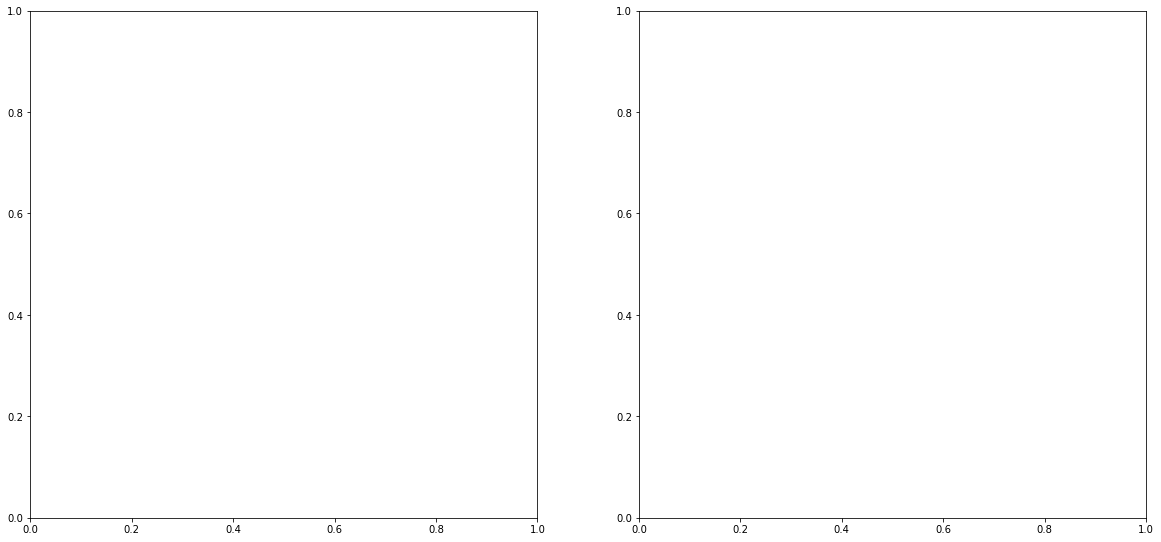

In [264]:
different_final = partner_file[equal_geoms == False]
different_src = rdh_file[equal_geoms == False]

fig, ax = plt.subplots(1, 2, figsize=(20,10))

different_src.plot(color="Red", ax=ax[0])
different_final.plot(color="Blue", ax=ax[1])